In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
fs = 15
resol = 0.0759

wsrc = '../hpcc/clean/'
tsrc = '../hpcc/watershed/'
rsrc = '../hpcc/rotated/'
dst = '../hpcc/traditional/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

ssrange = [100,150,200,250,300]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]

fs = 15

In [34]:
idname = '2012SB'

rownum = 16
treenum = 58
nutnum = 1

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

2012SB_R16_T58
../hpcc/traditional/2012SB_R16_T58/


In [35]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
mxval = 2**(8*img.itemsize)-1
tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

if True:
    air  = tf.imread(tissuefiles[0])
    meat = tf.imread(tissuefiles[1])
    shell= tf.imread(tissuefiles[2])
    vein = tf.imread(tissuefiles[3])

mxval = 2**(8*img.itemsize)

2012SB_R16_T58_001


In [50]:
cavity = np.zeros_like(img, dtype=np.bool)
cavity[air > 0] = True

cavity = wnut.get_largest_element(cavity)

cavity[meat > 0] = True
cavity[vein > 0] = True

dcav = ndimage.binary_dilation(cavity, struc3, 3, border_value=0)

fill = wnut.fill_component(dcav)

276 components	 1 preserved
[40096582   389519    16163     5657     2750     2535     2300     2275
     1305     1273     1270     1088      932      901      872      765
      572      568      563      560]
Closed X
Closed Y
Closed Z


In [51]:
N = 5
dfill = ndimage.binary_dilation(fill, struc1, N, border_value=0)
efill = ndimage.binary_erosion(dfill, struc1, 3*N, border_value=1)

cshell = shell * efill

In [52]:
bshell, labels, where = wnut.get_largest_element(cshell, thr=5e-3, outlabels=True)

1742 components	 6 preserved
[102331  89555  61442  49006   3558   2153   1421   1298   1239   1149
   1115    693    524    286    262    207    150    144    125    115]


In [39]:
objs = ndimage.find_objects(labels, np.max(where))
print(where)

[  1   3   4  17  55  66 100]


In [40]:
dist2center = np.zeros(len(where))

for i in range(len(where)):
    x0,y0,z0 = [objs[where[i]-1][j].start for j in range(img.ndim)]
    x1,y1,z1 = [objs[where[i]-1][j].stop  for j in range(img.ndim)]

    corners = [
        [x0,y0,z0],
        [x0,y0,z1],
        [x0,y1,z0],
        [x1,y0,z0],
        [x0,y1,z1],
        [x1,y0,z1],
        [x1,y1,z0],
        [x1,y1,z1]
    ]
    corners = np.asarray(corners)

    wcom = np.asarray(img.shape)//2

    cdists = np.sqrt(np.sum((corners - wcom)**2, axis=1))
    dist2center[i] = np.min(cdists)

In [41]:
dist2center

array([132.23463994,  68.73136111,  77.1621669 ,  95.82275304,
       179.64965906, 198.32801113, 182.12358441])

In [42]:
theta = np.linspace(0, 2*np.pi, 500)
diagdist = np.sqrt(np.sum(wcom ** 2))


radius = 0.35*diagdist
radius = 0.45*np.min(img.shape)
print(diagdist, radius, sep='\n')
cavarea = radius*np.column_stack((np.cos(theta), np.sin(theta)))

cavarea = cavarea.T

439.0990776578789
216.45000000000002


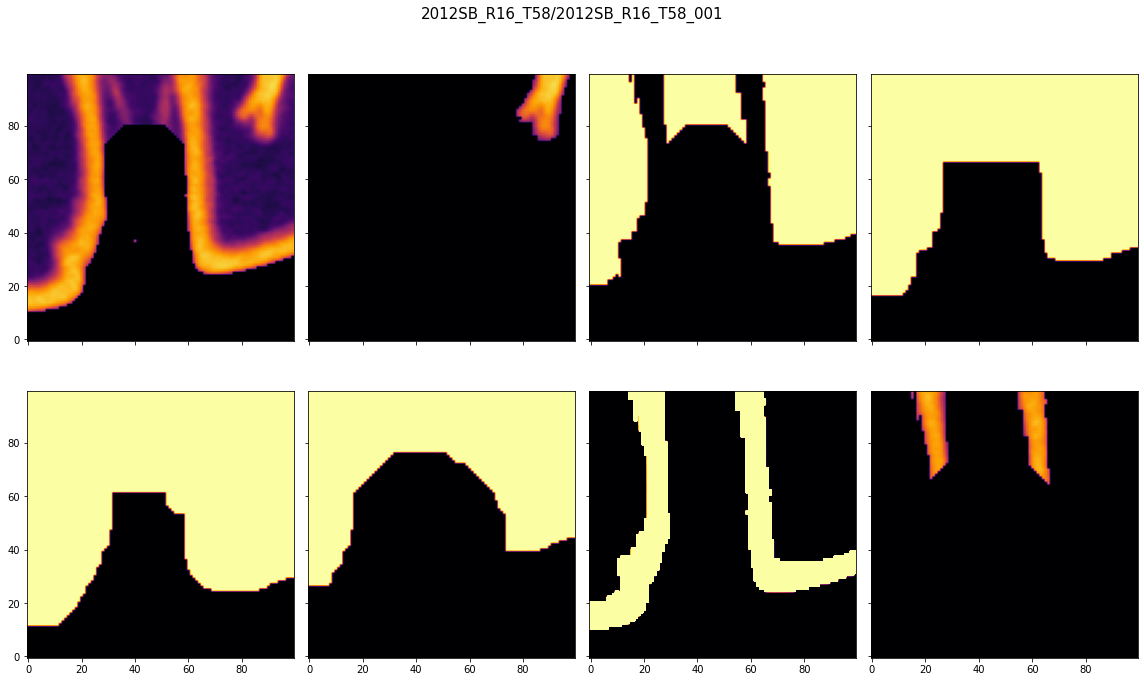

In [59]:
k = 200
ss = np.s_[:,:,k]
#ss = np.s_[k,:,:]
ss = np.s_[:100, 250:350, k]

fixcoord = np.nonzero([isinstance(ss[j], int) for j in range(3)])[0][0]
fcoords = [1,0]
if fixcoord == 0:
    fcoords = [2,1]
elif fixcoord == 1:
    fcoords = [2,0]
    
ccavarea = cavarea + wcom[fcoords].reshape(-1,1)

fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 2
ax[i].imshow(cavity[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(fill[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 4
ax[i].imshow(dfill[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 5
ax[i].imshow(efill[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 6
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(bshell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
#for i in range(len(ax)):
#    ax[i].scatter(*wcom[fcoords], marker='o', s=200, c='cyan', edgecolors='m', linewidths=3)
#    ax[i].plot(*ccavarea, c='cyan')

fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

In [47]:
img.shape

(516, 524, 481)

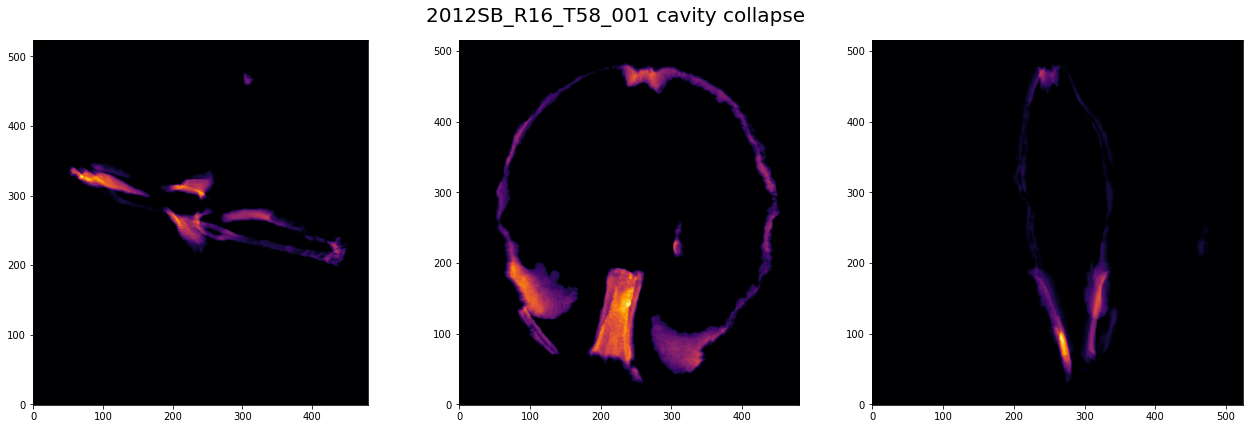

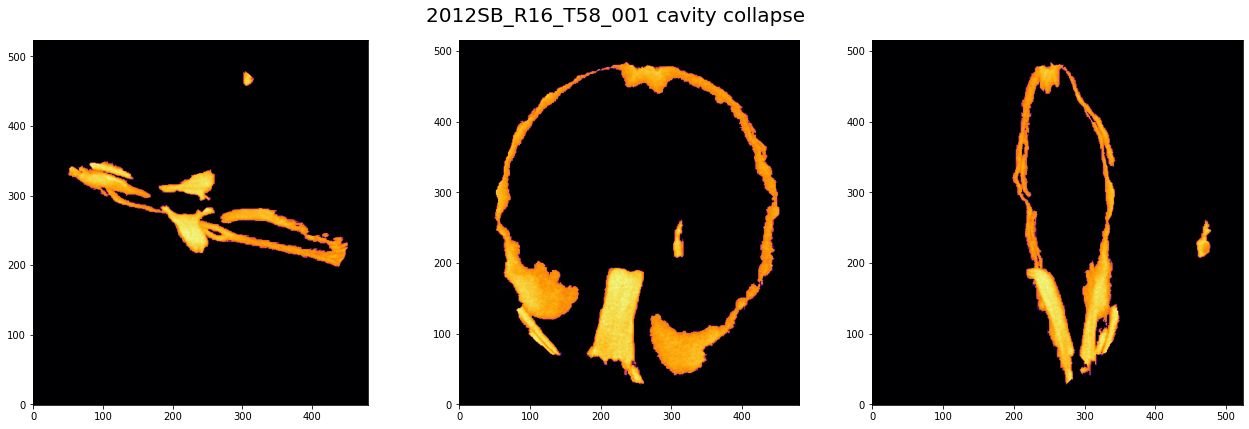

In [60]:
snaps = wnut.collapse_dimensions(bshell)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

snaps = wnut.collapse_dimensions_max(bshell)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)